# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import os
import shap
import random
import bisect
import warnings

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
from matplotlib          import pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine        as c

from pandas_profiling        import ProfileReport

from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier

from skopt                   import forest_minimize
from skopt.plots             import plot_convergence

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix


from sqlalchemy              import create_engine, inspect

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#========================================== Statistical Summary ==========================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



#========================================== Cramer V (Correlation) ==========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



#========================================= Group Age by an Age Stage =========================================#
def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]


#========================================== Machine Learning Scores ==========================================#
def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                       'Precision': precision, 
                       'Recall': recall,
                       'F1 Score': f1,
                       'Kappa': kappa,
                       'Balanced Accuracy': balanced_accuracy,
                       'Average Precision Score': ap,
                       'ROC AUC': roc_auc}, index=[0])


#====================================== Machine Learning Cross Validation ======================================#
def cross_validation(X_train, y_train, model, num_folds=5, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    model_name = type(model).__name__

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
            
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

### 0.3.1 Check Schemas & Tables

In [5]:
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
usenamer = os.environ.get('POSTGRES_CDS_USERNAME')
password = os.environ.get('POSTGRES_CDS_PASSWORD')
port = 5432
database = 'comunidadedsdb'

engine = create_engine(f"postgresql://{usenamer}:{password}@{host}:{port}/{database}")

inspector = inspect(engine)

# get schemas
schemas = inspector.get_schema_names()

for schema in schemas:
    if (schema != 'information_schema') & (schema != 'public'):
        # list of tables in each schema
        print('schema: {}'.format(schema))
        tables = inspector.get_table_names(schema=schema)
        for table in tables:
            print('table: {}'.format(table))

schema: pa004
table: users
table: vehicle
table: insurance


### 0.3.2 Query Data

In [6]:
with open('../02-Query/raw_data.sql', mode='r', encoding='utf-8-sig') as query:
    query_raw_data = query.read()


with engine.connect() as conn:
    df_raw = pd.read_sql(query_raw_data, conn)

In [7]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


### 0.3.5 Saving Test Data

In [8]:
#Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
train_dataset.to_feather('../00-Data/training_data.feather')
test_dataset.to_feather('../00-Data/test_data.feather')

### 0.3.6 Read Training Dataset

In [9]:
df_train = pd.read_feather('../00-Data/training_data.feather')
#df_train = df_raw.copy()


# 1.0 DATA DESCRIPTION

In [10]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,288125,Female,24,37.0,151.0,1,< 1 Year,No,1,41352.0,12,0
1,204747,Male,43,28.0,124.0,1,1-2 Year,No,0,29433.0,223,0
2,248900,Male,41,3.0,26.0,1,1-2 Year,Yes,0,20513.0,238,1
3,219679,Male,23,11.0,152.0,1,< 1 Year,No,1,2630.0,272,0
4,166465,Female,23,47.0,152.0,1,< 1 Year,No,1,46554.0,57,0


## 1.1 Data Dimensions

In [11]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 304887
Number of Columns: 12


## 1.2 Data Type

In [12]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [13]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## ~~1.4 Change Data type~~

## 1.5 Check Balanced Data

In [14]:
df01['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [15]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [16]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.816020,36.0,21.0,22.0,25.0,49.0,62.0,69.0,15.515967,0.399731,0.673939,-0.564887
1,region_code,0.0,52.0,52.0,28.0,26.395045,28.0,5.0,8.0,15.0,35.0,46.0,47.0,13.228285,0.501165,-0.114913,-0.868250
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.059042,136.0,26.0,26.0,29.0,152.0,156.0,160.0,54.205776,0.483725,-0.900722,-0.969580
3,driving_license,0.0,1.0,1.0,1.0,0.997891,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.045875,0.045972,-21.706452,469.173124
4,previously_insured,0.0,1.0,1.0,0.0,0.458321,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.498260,1.087142,0.167301,-1.972023
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30540.895260,31659.0,2630.0,2630.0,24374.0,39403.0,48436.0,55143.4,17216.061654,0.563705,1.797548,35.488332
6,vintage,10.0,299.0,289.0,73.0,154.332438,154.0,24.0,38.0,82.0,227.0,270.0,285.0,83.653941,0.542037,0.003552,-1.199702
7,response,0.0,1.0,1.0,0.0,0.122563,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.327935,2.675638,2.301907,3.298797


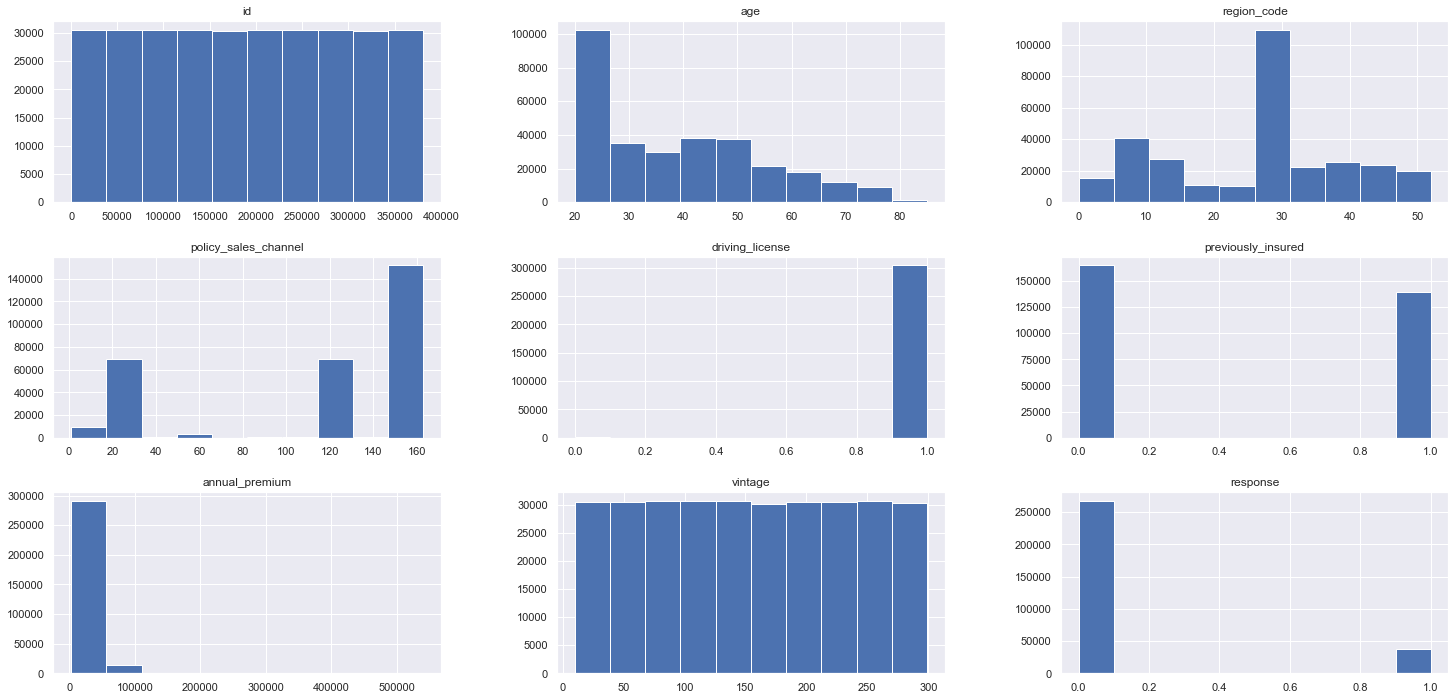

In [17]:
num_attributes.hist();

### 1.6.2 Categorical Attributes

In [18]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164828,160204,153804


### 1.6.3 Some Conclusions

Significant portion of customers (54,2%) don't have vehicle insurance
 
Most 95% of customer have license

All customers have less than one year of insurance and have a constant distribution 

Most customers are under 50 years old, 25% are up to 25 years old 

Most 95% of annual premmium cost until 55.292 and the range is 537535.0

Most customer are Male

Most customers vehicles age is less 2 years

Customers who have had the vehicle damaged in the past are evenly distributed to customers who have not had the vehicle damaged

Most 75% of customers don't have interest to buy a vehicle insurance

# 2.0 Feature Engineering

In [19]:
df02 = df01.copy()

In [20]:
# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)

# vehicle demage versus license
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)
df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


# vehicle_damage_vehicle_age
df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

# age / mean_age_by_region_code
region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
del region_code_mean_age


# age / mean_age_by_policy_sales_channel
policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# annual_premium / mean_annual_premium_by_region_code
region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# annual_premium / mean_annual_premium_by_policy_sales_channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

# age / vintage
df02['age_vintage'] = (df02['age']*365) / df02['vintage']

In [21]:
df02.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_stage,vehicle_damage_license,vehicle_damage_vehicle_age,mean_age_by_region_code,age_mean_age_by_region_code,mean_age_by_policy_sales_channel,age_mean_age_by_policy_sales_channel,mean_annual_premium_by_region_code,annual_premium_mean_annual_premium_by_region_code,mean_annual_premium_by_policy_sales_channel,annual_premium_mean_annual_premium_by_policy_sales_channel,age_vintage
0,288125,Female,24,37.0,151.0,1,0,0,1,41352.0,12,0,Young,1,0,32.396548,0.740820,25.524559,0.940271,28470.573246,1.452447,29099.208347,1.421070,730.000000
1,204747,Male,43,28.0,124.0,1,1,0,0,29433.0,223,0,Adult,1,1,46.243037,0.929870,46.902883,0.916788,38657.974946,0.761369,31700.398681,0.928474,70.381166
2,248900,Male,41,3.0,26.0,1,1,1,0,20513.0,238,1,Adult,4,-4,36.833879,1.113106,50.682988,0.808950,24669.036143,0.831528,33620.416308,0.610135,62.878151
3,219679,Male,23,11.0,152.0,1,0,0,1,2630.0,272,0,Young,1,0,34.392636,0.668748,26.207445,0.877613,27639.675479,0.095153,30865.274962,0.085209,30.863971
4,166465,Female,23,47.0,152.0,1,0,0,1,46554.0,57,0,Young,1,0,34.913836,0.658765,26.207445,0.877613,30166.089510,1.543256,30865.274962,1.508297,147.280702


# 3.0 Data Filtering

In [22]:
df03 = df02.copy()

## 3.1 Filtering Rows

## 3.2 Filtering Columns

In [23]:
cols_drop = ['id', # original data
             'mean_age_by_region_code', 'mean_age_by_policy_sales_channel', 'mean_annual_premium_by_region_code', 'mean_annual_premium_by_policy_sales_channel'] # auxiliary features
df03 = df03.drop(cols_drop, axis=1)

# 4.0 Balanced Dataset

In [24]:
df04 = df03.copy()

## 4.1 SMOTE + TOMEKLINK

In [25]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df04.select_dtypes(include=['int64', 'float64']).drop('response', axis=1).columns.tolist()

# Categorical
col_cat = df04.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Encoding
df04_dummy = pd.DataFrame(ohe.fit_transform(df04[col_cat]).toarray(), index=df04.index)

# join Numerical and Categorical
df04_1 = pd.concat([df04[col_num], df04_dummy], axis=1)

In [26]:
ratio_balanced = {
                    0: 334399,
                    1: 8*37368
                }

#ratio_balanced

In [27]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df04_1, df04['response'])

In [28]:
# numerical data
df04_2 = X_smt[col_num]

# categorical data
df04_3 = X_smt.drop(col_num, axis=1)
df04_4 = pd.DataFrame(ohe.inverse_transform(df04_3), columns=col_cat, index=df04_3.index)

# join numerical and categorical
df04_5 = pd.concat([df04_2, df04_4], axis=1)
df04_5['response'] = y_smt

# 5.0 Exploratory Data Analysis (EDA)

In [29]:
df05_u = df04.copy()
df05 = df04_5.copy()

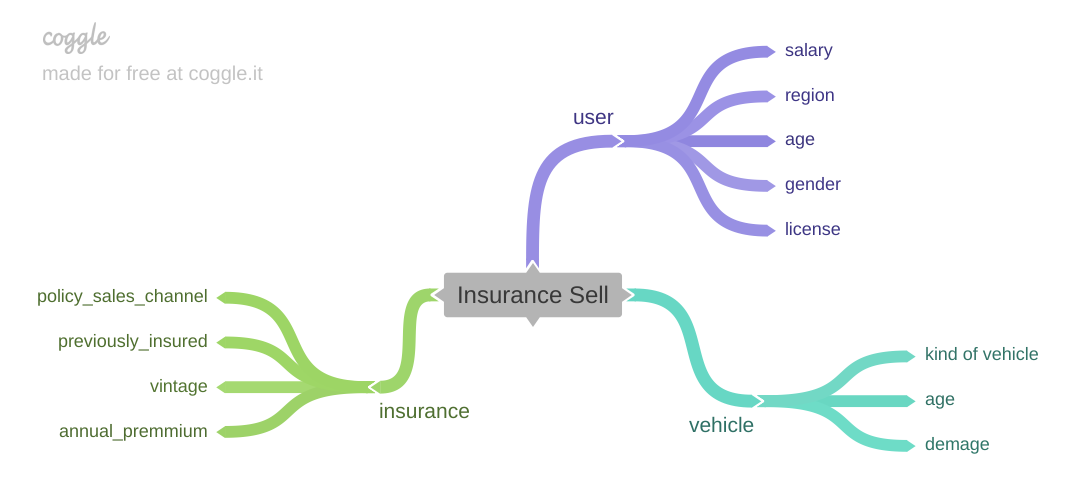

In [30]:
Image('../img/insurance_sell.png')

## 5.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

In [31]:
profile = ProfileReport(df05, title="Insurance Cross Sell", html={'style': {'full_width':True}}, minimal=True)

profile.to_file(output_file='insurance_cross_sell.html')

## 5.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

### 5.2.1 Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance more frequently
> - **H02** - Unlicensed customers do not purchase insurance
> - **H03** - Customers who already have vehicle insurance do not require the insurance offered
> - **H04** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H05** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H06** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H07** - Older customers in the portfolio acquire insurance
> - **H08** - Elderly customers do not purchase insurance
> - **H09** - Female customers already have vehicle insurance
> - **H10** - Customers with new and damaged vehicles purchase insurance
> - **H11** - Customers who have a plan that costs more than the average in the region acquire insurance
> - **H12** - Older customers in the portfolio are from the region 28
> - **H13** - Young customers came through channel 152
> - **H14** - Among the damaged cars, the largest portion belongs to young customers 

### 5.2.2 Final List of Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance
> - **H02** - Customers who already have vehicle insurance do not require the insurance offered
> - **H03** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H04** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance

#### **H01** - Customers over 30 years old purchase vehicle insurance more frequently
---
> **Conclusion: TRUE**
>> - Customers over 30 years old purchase vehicle insurance more frequently

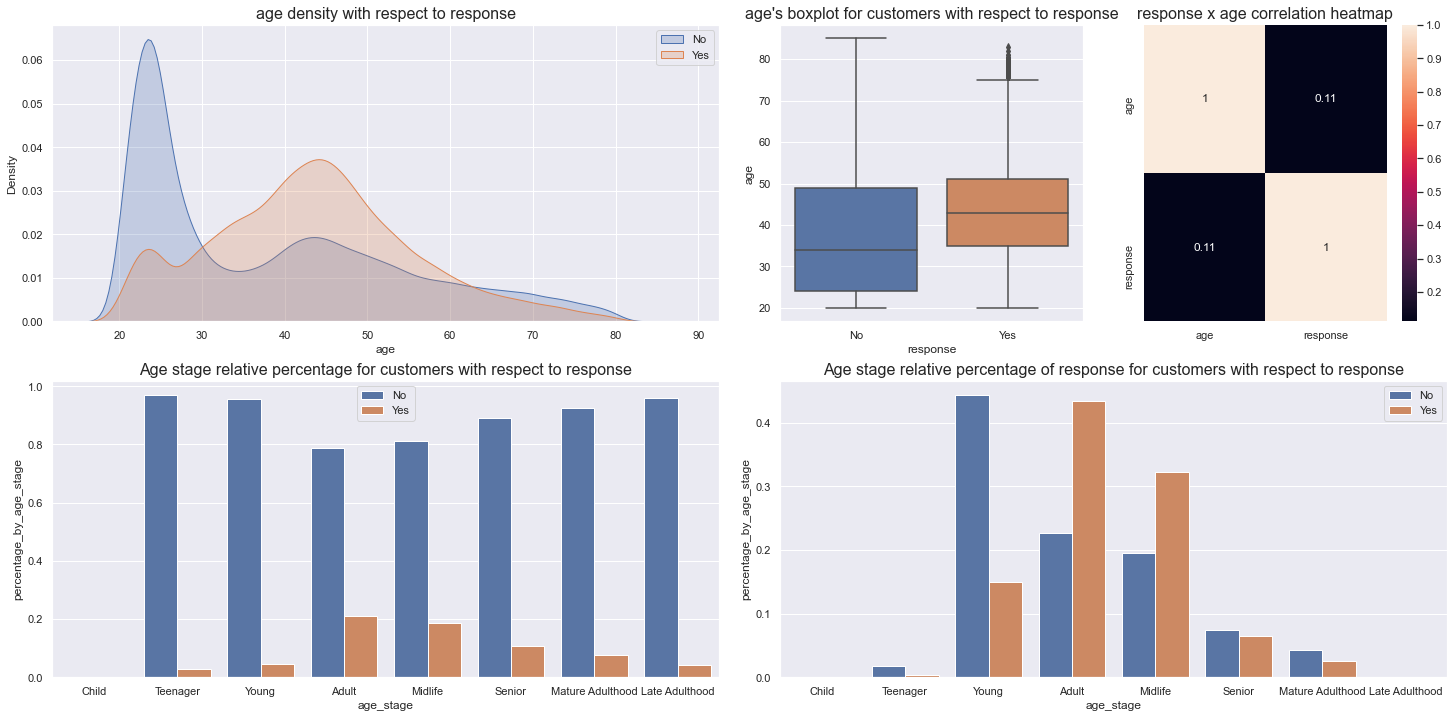

In [32]:
aux01 = df05_u[['age', 'age_stage', 'response']]


# Grid for ploting
grid = GridSpec(2, 4)

# response x age correlation heatmap
plt.subplot(grid[0,3:4])
sns.heatmap(aux01.corr(method='pearson'), annot=True).set_title("response x age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux01['response'] = aux01['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# age density with respect to response
plt.subplot(grid[0,:2])
sns.kdeplot(aux01[aux01['response'] == 'No']['age'], label='No', shade=True);
sns.kdeplot(aux01[aux01['response'] == 'Yes']['age'], label='Yes', shade=True);
plt.title("age density with respect to response", fontsize=16);
plt.legend();

# age's boxplot for customers with respect to response
plt.subplot(grid[0,2:3])
sns.boxplot(x="response", y="age", data=aux01).set_title("age's boxplot for customers with respect to response", fontsize=16);

# Age stage relative percentage for customers with respect to response
aux02 = pd.DataFrame()
age_stage_unique = aux01['age_stage'].unique().tolist()
for stage in age_stage_unique:
    aux02_0 = aux01[aux01['age_stage'] == stage][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
    aux02 = pd.concat([aux02, aux02_0])

## sort the x axis
age_stage_order = ['Child', 'Teenager', 'Young', 'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood']
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02);
plt.legend();
plt.title("Age stage relative percentage for customers with respect to response", fontsize=16);

# Age stage relative percentage of response for customers with respect to response
aux02_0 = aux01[aux01['response'] == 'No'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
aux02_1 = aux01[aux01['response'] == 'Yes'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})

aux02 = pd.concat([aux02_0, aux02_1], axis=0)

## sort the x axis
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,2:4])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02);
plt.legend();
plt.title("Age stage relative percentage of response for customers with respect to response", fontsize=16);

#### **H02** - Customers who already have vehicle insurance do not require the insurance offered
---
> **Conclusion: TRUE**
>> - Customers who already have vehicle insurance do not require the insurance offered

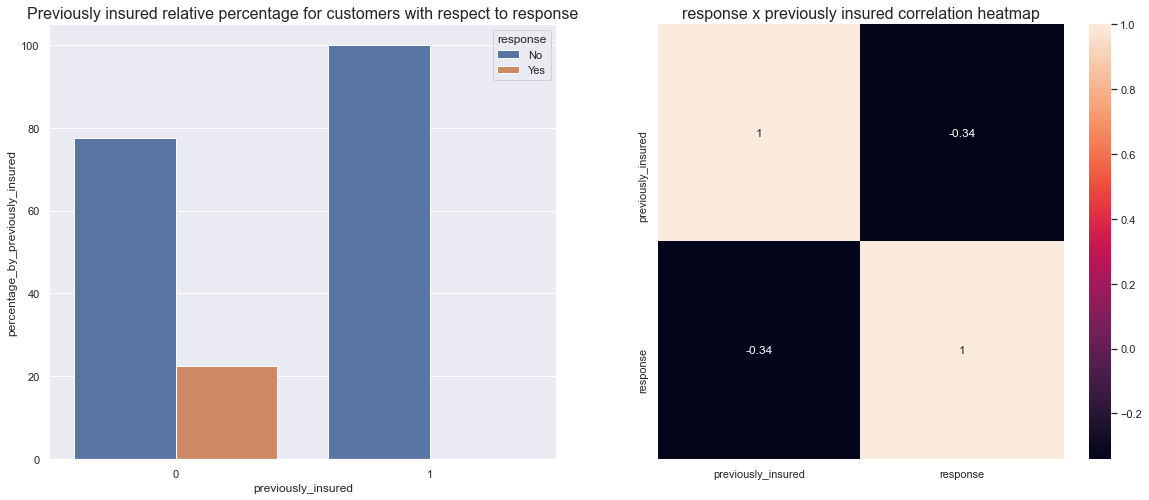

In [33]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
aux02 = df05_u[['previously_insured', 'response']]
# Previously insured relative percentage for customers with respect to response
aux02_0 = aux02[aux02['previously_insured'] == 1][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux02_1 = aux02[aux02['previously_insured'] == 0][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux03 = pd.concat([aux02_0, aux02_1], axis=0)

## Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
## transform to 100%
aux03['percentage_by_previously_insured'] = aux03['percentage_by_previously_insured'] * 100

## plot
sns.barplot(x='previously_insured', y='percentage_by_previously_insured', hue='response', data=aux03);
plt.title("Previously insured relative percentage for customers with respect to response", fontsize=16)

# response x previously insured correlation heatmap
plt.subplot(1,2,2)
sns.heatmap(aux02.corr(method='pearson'), annot=True).set_title("response x previously insured correlation heatmap", fontsize=16);

#### **H03** - Customers with vehicle that are less than 1 year old purchase insurance
---
> **Conclusion: FALSE**
>> - Customers with vehicle that are less than 1 year old do not purchase insurance

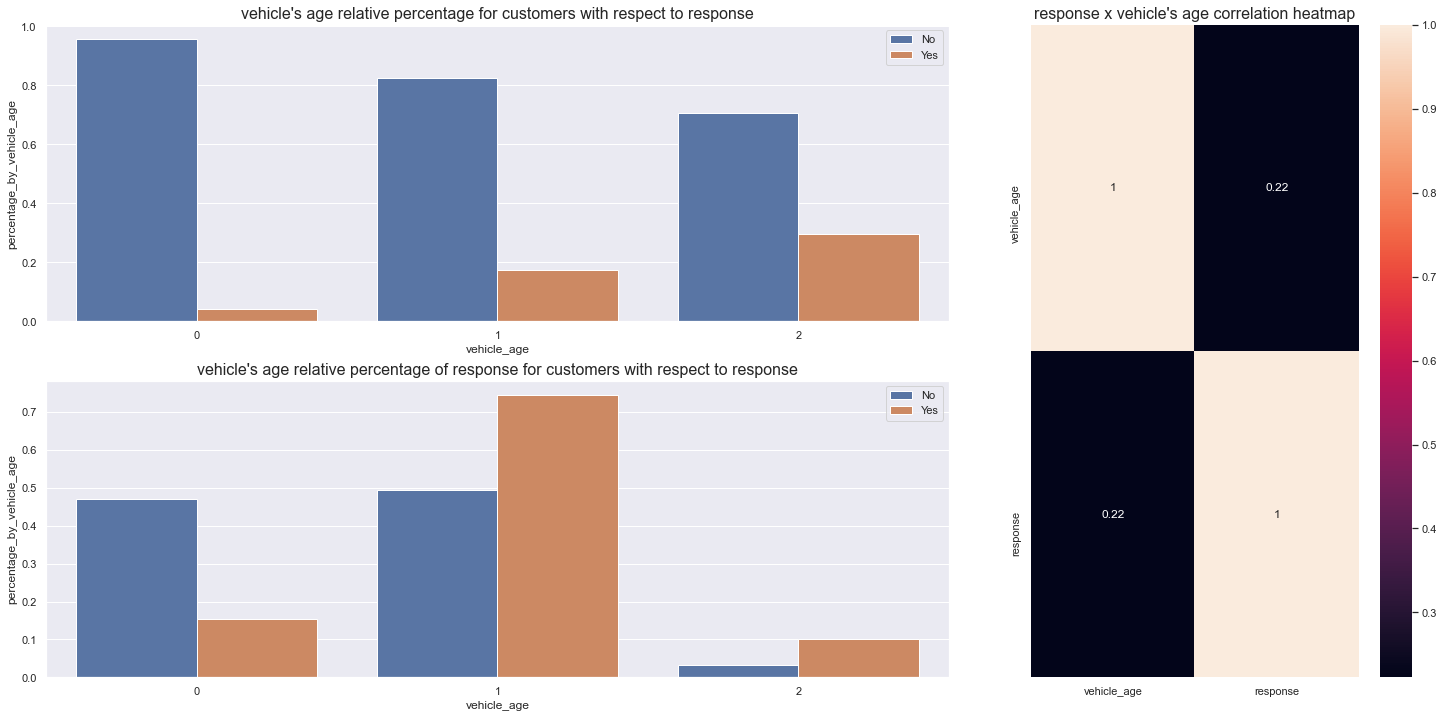

In [34]:
aux03 = df05_u[['vehicle_age', 'response']]

# Grid for ploting
plt.figure(figsize=(25, 12))
grid = GridSpec(2, 3)

# response x vehicle's age correlation heatmap
plt.subplot(grid[:,2])
sns.heatmap(aux03.corr(method='pearson'), annot=True).set_title("response x vehicle's age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# vehicle's age relative percentage for customers with respect to response
aux04 = pd.DataFrame()
vehicle_age_unique = aux03['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    aux04_0 = aux03[aux03['vehicle_age'] == age][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    aux04 = pd.concat([aux04, aux04_0])

## plot
plt.subplot(grid[0,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux04);
plt.legend();
plt.title("vehicle's age relative percentage for customers with respect to response", fontsize=16);



# Age stage relative percentage of response for customers with respect to response
aux03_0 = aux03[aux03['response'] == 'No'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03_1 = aux03[aux03['response'] == 'Yes'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03 = pd.concat([aux03_0, aux03_1], axis=0)

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux03);
plt.legend();
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

#### **H04** -  Longer customers who own vehicles that are more than 2 years old acquire insurance
---
> **Conclusion: FALSE**
>> - Longer customers who own vehicles that are more than 2 years old acquire insurance in the same frequency of the other customers

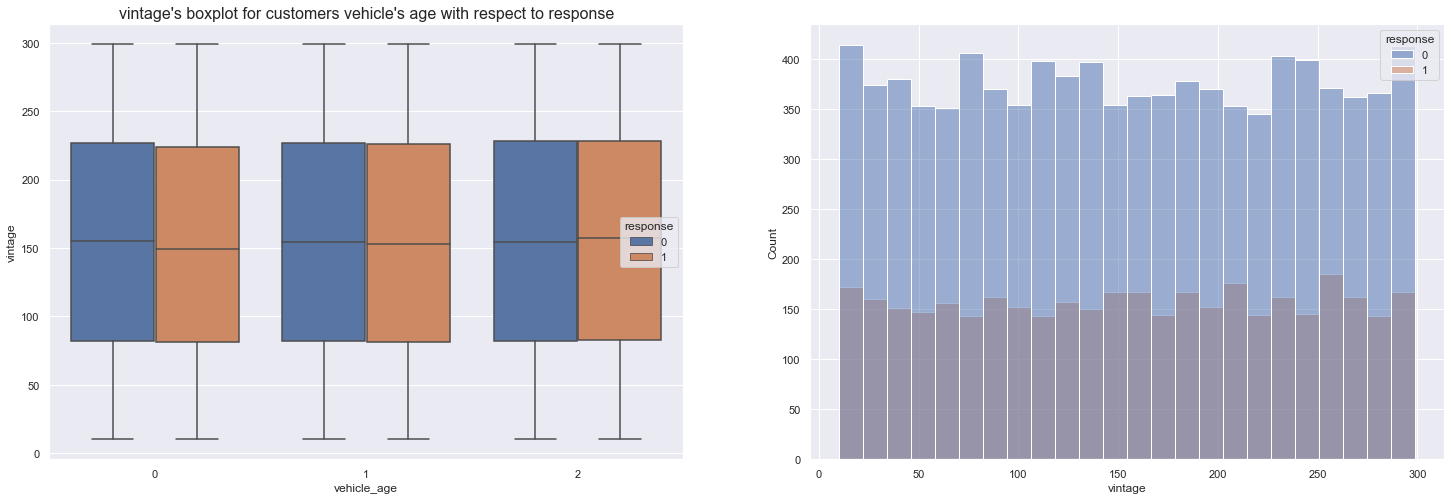

In [35]:
aux04 = df05_u[['vintage','vehicle_age', 'response']]

plt.figure(figsize=(25,8))
# age's boxplot for customers with respect to response
plt.subplot(1,2,1)
sns.boxplot(x="vehicle_age", y="vintage", hue="response", data=aux04).set_title("vintage's boxplot for customers vehicle's age with respect to response", fontsize=16);

plt.subplot(1,2,2)
sns.histplot(x='vintage', data=aux04[aux04['vehicle_age'] == 2], hue='response');

#### **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
---
> **Conclusion: **
>> - 

## 5.3 Multivariable analysis (Balanced Dataset)

In [36]:
num_attributes = df05.select_dtypes(include=['int64', 'float64'])
cat_attributes = df05.select_dtypes(exclude=['int64', 'float64'])

### 5.3.1 Numerical

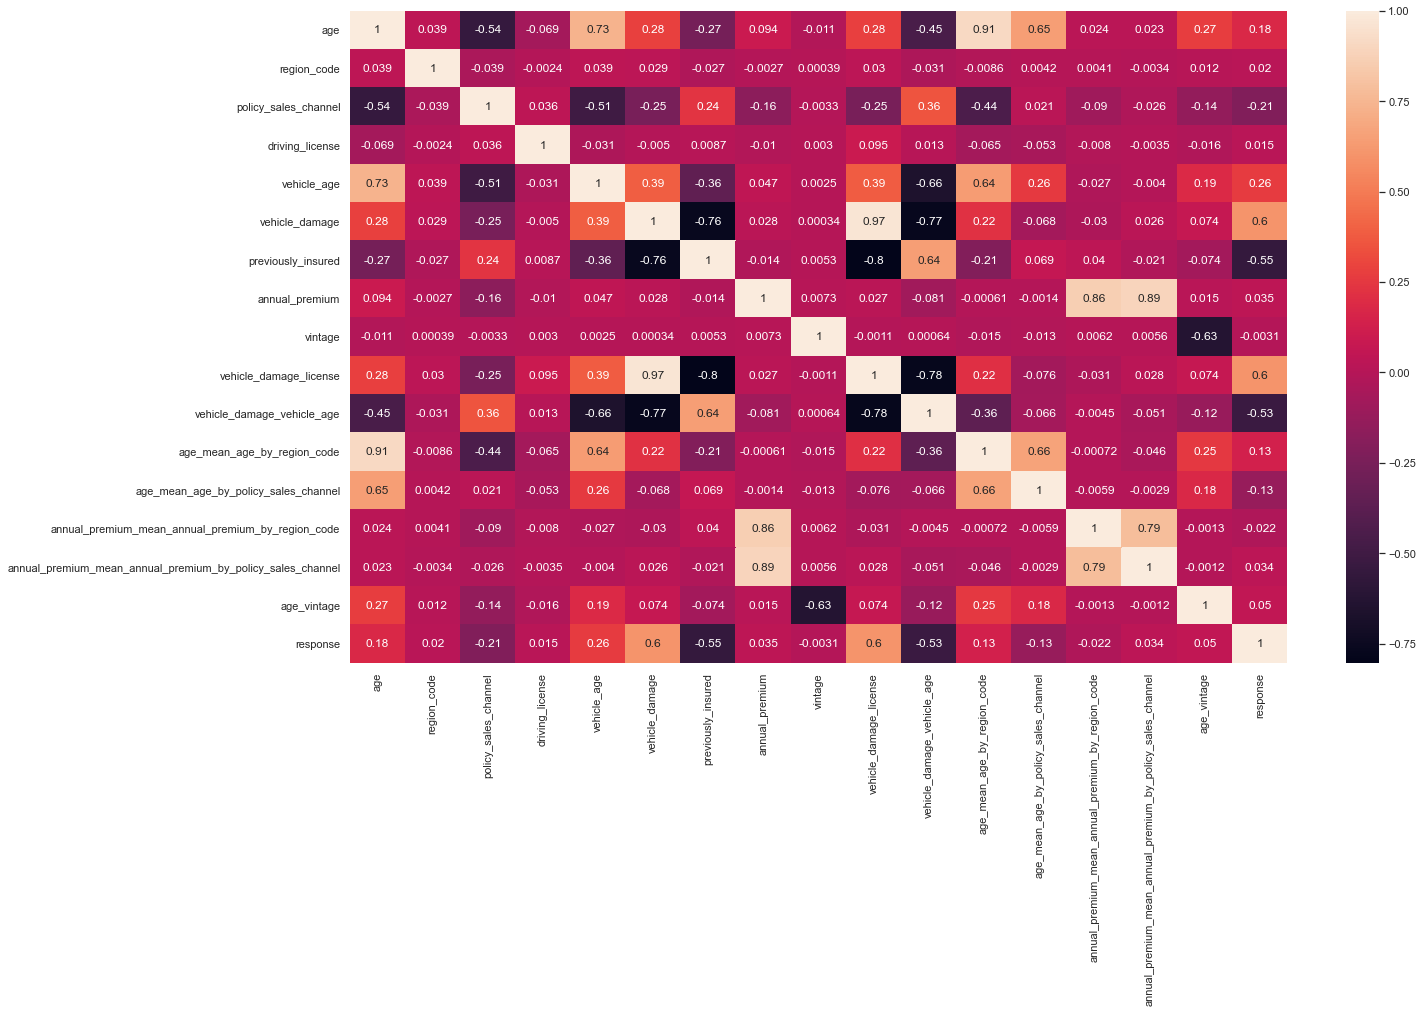

In [37]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 5.3.2 Categorical

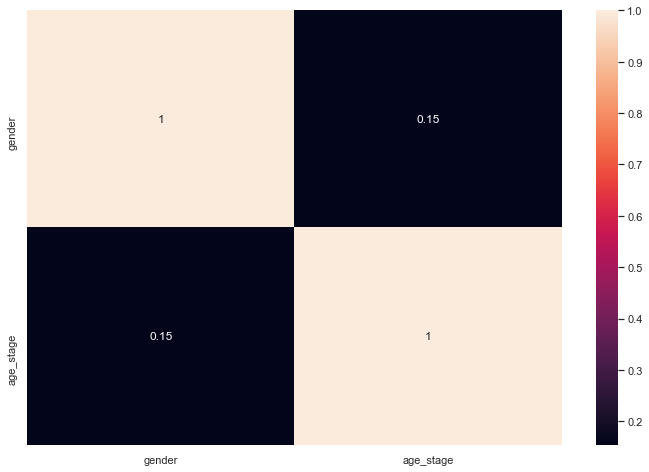

In [38]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(12,8))
sns.heatmap(d, annot=True);

# 6.0 Data Filtering (Attributes with High Correlation)

In [39]:
cols_drop = ['age', 'vehicle_damage', 'annual_premium']
df06 = df05.drop(cols_drop, axis=1)

#df06 = df05.copy() ### will be changed

# 7.0 Data Preparation

In [40]:
# Numerical
num_attributes = df06.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df06.select_dtypes(exclude=['int64', 'float64'])

## 7.1 Rescaling

## 7.2 Encoding

In [41]:
# Dummy variable
df07_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df07 = pd.concat([num_attributes, df07_dummy], axis=1)

## 7.3 Transformation

# 8.0 Feature Selection

In [42]:
df08 = df07.copy()

## 8.1 Boruta as Feature Selector

In [43]:
X = df08.drop(columns=['response'], axis=1)
y = df08['response'].copy()


# Training and Validation dataset for Boruta
X_train_n = X.to_numpy()
y_train_n = y.values.ravel()

# define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, verbose=1, n_estimators='auto', random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	11


BorutaPy(estimator=RandomForestClassifier(n_estimators=66, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x249BECA3640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x249BECA3640, verbose=1)

In [44]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['region_code',
 'policy_sales_channel',
 'previously_insured',
 'vintage',
 'vehicle_damage_license',
 'vehicle_damage_vehicle_age',
 'age_mean_age_by_region_code',
 'age_mean_age_by_policy_sales_channel',
 'annual_premium_mean_annual_premium_by_region_code',
 'annual_premium_mean_annual_premium_by_policy_sales_channel',
 'age_vintage']

## 8.2 Split into Train and Validation

In [167]:
# cols_selected = ['age',
#                  'region_code',
#                  'policy_sales_channel',
#                  'vehicle_damage',
#                  'previously_insured',
#                  'annual_premium',
#                  'vintage',
#                  'vehicle_damage_license',
#                  'vehicle_damage_vehicle_age',
#                  'age_mean_age_by_region_code',
#                  'age_mean_age_by_policy_sales_channel',
#                  'annual_premium_mean_annual_premium_by_region_code',
#                  'annual_premium_mean_annual_premium_by_policy_sales_channel',
#                  'age_vintage']

cols_selected = ['region_code',
                 'policy_sales_channel',
                 'previously_insured',
                 #'vintage',
                 'vehicle_damage_license',
                 'vehicle_damage_vehicle_age',
                 #'age_mean_age_by_region_code',
                 'age_mean_age_by_policy_sales_channel',
                 #'annual_premium_mean_annual_premium_by_region_code',
                 #'annual_premium_mean_annual_premium_by_policy_sales_channel',
                 'age_vintage']


X = df08[cols_selected]
Y = df08['response'].copy()

# Split into temporary dataset and Test dataset
x, X_test, y, y_test = train_test_split(X, Y, test_size=0.1, random_state=32, stratify=Y)

# Split into Train and Validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=32, stratify=y)

# 9.0 Machine Learning Model

## 9.1 Baseline model

### 9.1.1 Random Choices

In [168]:
response_list = y_train.drop_duplicates().sort_values().tolist()
response_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_valid.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 9.1.2 Random Choices Performance

Accuracy: 0.5003877247243589
Balanced Accuracy: 0.4987302299557472
Kappa Score: -0.002539723505314617
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     59287
           1       0.47      0.47      0.47     52906

    accuracy                           0.50    112193
   macro avg       0.50      0.50      0.50    112193
weighted avg       0.50      0.50      0.50    112193



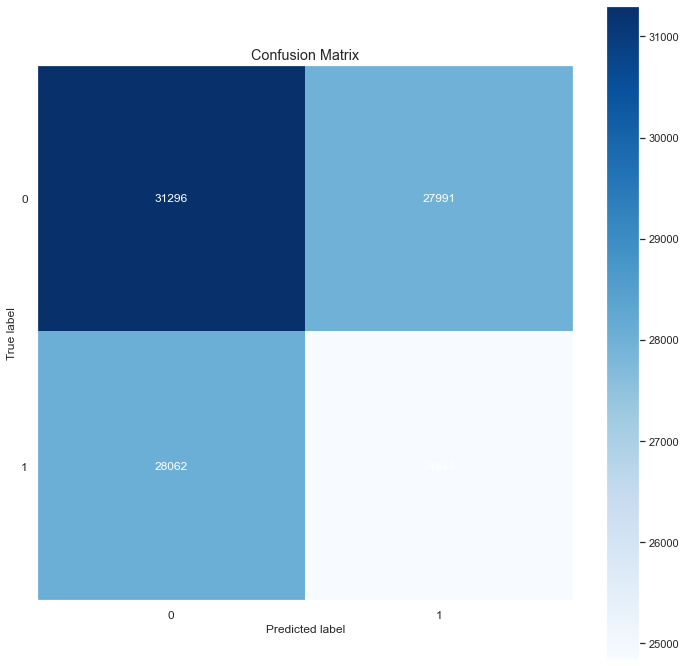

In [169]:
# Accuracy
acc_random = accuracy_score(y_valid, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_valid, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_valid, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_valid, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_random, normalize=False, figsize=(12, 12));

## 9.2 Machine Learning Model

### 9.2.1 Random Forest

In [170]:
# Model
rf = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

yhat_rf = rf.predict(X_valid)

#### 9.2.1.1 Performance

Accuracy: 0.7864216127565891
Balanced Accuracy: 0.7959113973273133
Kappa Score: 0.5800104097079857
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     59287
           1       0.70      0.96      0.81     52906

    accuracy                           0.79    112193
   macro avg       0.82      0.80      0.78    112193
weighted avg       0.83      0.79      0.78    112193



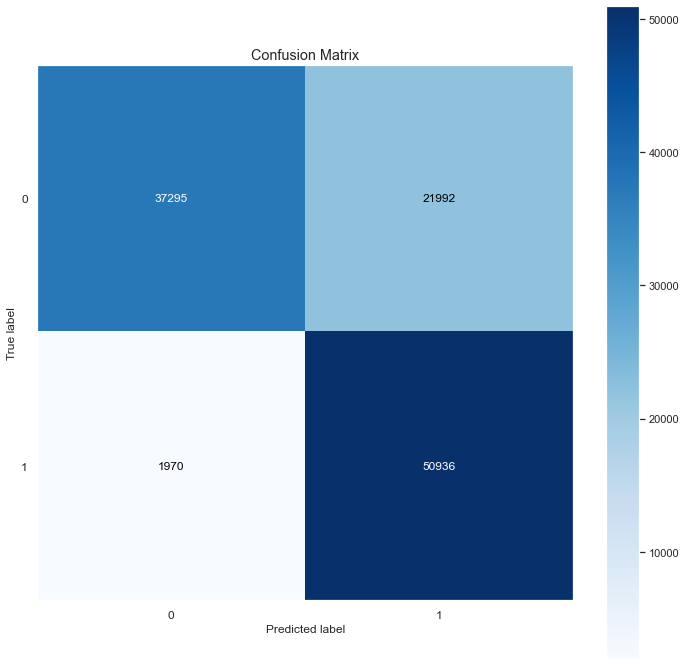

In [171]:
# Accuracy
acc_rf = accuracy_score(y_valid, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_valid, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_valid, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_valid, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_rf, normalize=False, figsize=(12, 12));

#### 9.2.1.2 Performance - Cross Validation

In [172]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)

# cross validation
result_rf = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_rf

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,RandomForestClassifier,0.7 +/- 0.0016,0.9629 +/- 0.0011,0.8107 +/- 0.001,0.5828 +/- 0.0026,0.7973 +/- 0.0013,0.7923 +/- 0.0053,0.8637 +/- 0.0024


### 9.2.2 XGBoost Classifier

In [173]:
xgb = XGBClassifier(max_depth=2, n_jobs=-1, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = xgb.predict(X_valid)

#### 9.2.2.1 Performance

Accuracy: 0.8411130819213319
Balanced Accuracy: 0.8446162943949673
Kappa Score: 0.6837369218583388
              precision    recall  f1-score   support

           0       0.90      0.78      0.84     59287
           1       0.79      0.91      0.84     52906

    accuracy                           0.84    112193
   macro avg       0.85      0.84      0.84    112193
weighted avg       0.85      0.84      0.84    112193



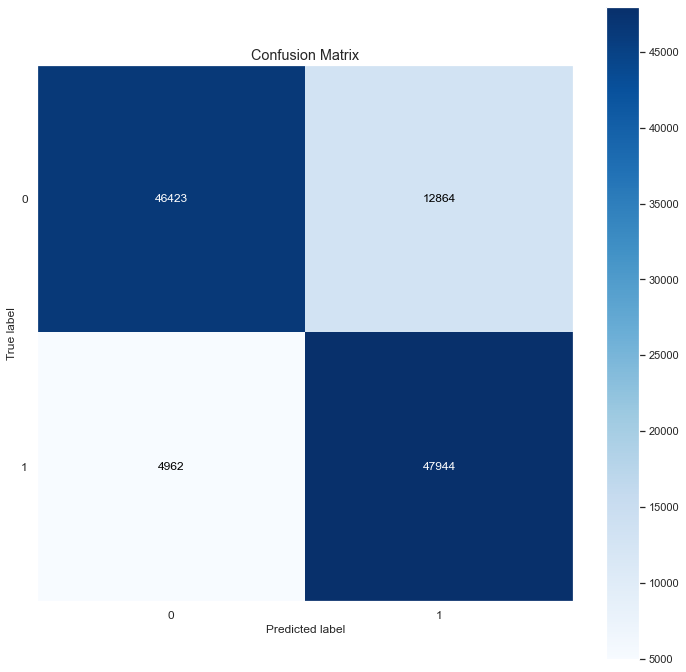

In [174]:
# Accuracy
acc_xgb = accuracy_score(y_valid, yhat_xgb)
print('Accuracy: {}'.format(acc_xgb))

# Balanced Accuracy
balanced_acc_xgb = balanced_accuracy_score(y_valid, yhat_xgb)
print('Balanced Accuracy: {}'.format(balanced_acc_xgb))

# Kappa Score
kappa_xgb = cohen_kappa_score(y_valid, yhat_xgb)
print('Kappa Score: {}'.format(kappa_xgb))

# Classification Report
print(classification_report(y_valid, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_xgb, normalize=False, figsize=(12, 12));

#### 9.2.2.2 Performance - Cross Validation

In [175]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = XGBClassifier(max_depth=2, n_jobs=-1, random_state=42, verbosity=0)

# cross validation
result_xgb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.7889 +/- 0.0014,0.9061 +/- 0.0017,0.8434 +/- 0.0011,0.6843 +/- 0.0022,0.8449 +/- 0.0011,0.9039 +/- 0.0011,0.9267 +/- 0.0009


### 9.2.3 LightGBM Classifier

In [176]:
lgbm = LGBMClassifier(max_depth=2, n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)

# Prediction
yhat_lgbm = lgbm.predict(X_valid)

#### 9.2.3.1 Performance

Accuracy: 0.8267538973019707
Balanced Accuracy: 0.8317937381363543
Kappa Score: 0.656234922889962
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     59287
           1       0.76      0.92      0.83     52906

    accuracy                           0.83    112193
   macro avg       0.84      0.83      0.83    112193
weighted avg       0.84      0.83      0.83    112193



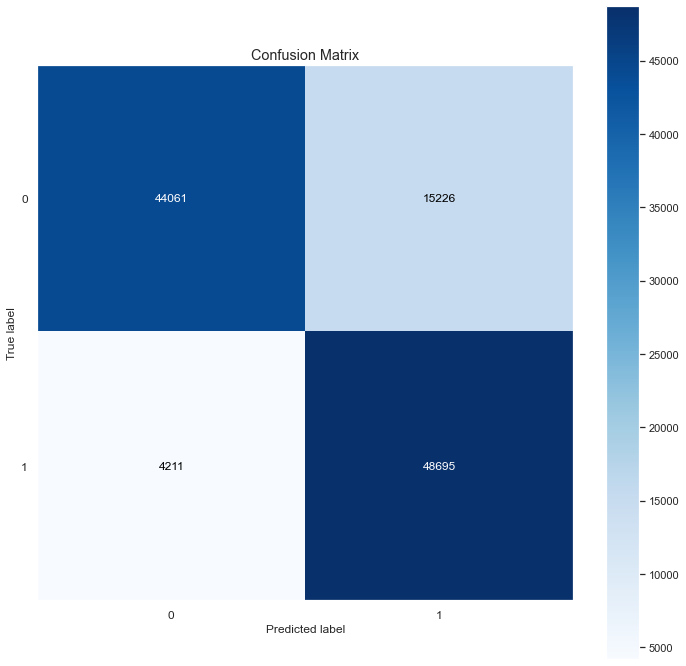

In [177]:
# Accuracy
acc_lgbm = accuracy_score(y_valid, yhat_lgbm)
print('Accuracy: {}'.format(acc_lgbm))

# Balanced Accuracy
balanced_acc_lgbm = balanced_accuracy_score(y_valid, yhat_lgbm)
print('Balanced Accuracy: {}'.format(balanced_acc_lgbm))

# Kappa Score
kappa_lgbm = cohen_kappa_score(y_valid, yhat_lgbm)
print('Kappa Score: {}'.format(kappa_lgbm))

# Classification Report
print(classification_report(y_valid, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_lgbm, normalize=False, figsize=(12, 12));

#### 9.2.3.2 Performance - Cross Validation

In [178]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = LGBMClassifier(max_depth=2, n_jobs=-1, random_state=42)

# cross validation
result_lgbm = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LGBMClassifier,0.761 +/- 0.001,0.9185 +/- 0.0012,0.8323 +/- 0.0006,0.6537 +/- 0.0013,0.8305 +/- 0.0006,0.8695 +/- 0.0014,0.9043 +/- 0.0008


### 9.2.4 Catboost Classifier

In [179]:
catb = CatBoostClassifier(depth=2, random_state=42, verbose=False)
catb.fit(X_train, y_train)

# Prediction
yhat_catb = catb.predict(X_valid)

#### 9.2.4.1 Performance

Accuracy: 0.858823634273083
Balanced Accuracy: 0.8610736966001109
Kappa Score: 0.7182569970758541
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     59287
           1       0.82      0.90      0.86     52906

    accuracy                           0.86    112193
   macro avg       0.86      0.86      0.86    112193
weighted avg       0.86      0.86      0.86    112193



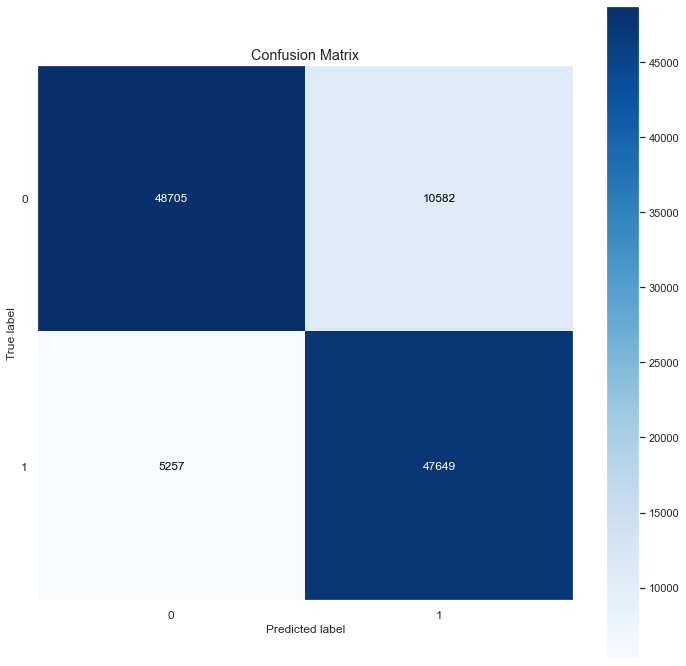

In [180]:
# Accuracy
acc_catb = accuracy_score(y_valid, yhat_catb)
print('Accuracy: {}'.format(acc_catb))

# Balanced Accuracy
balanced_acc_catb = balanced_accuracy_score(y_valid, yhat_catb)
print('Balanced Accuracy: {}'.format(balanced_acc_catb))

# Kappa Score
kappa_catb = cohen_kappa_score(y_valid, yhat_catb)
print('Kappa Score: {}'.format(kappa_catb))

# Classification Report
print(classification_report(y_valid, yhat_catb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_catb, normalize=False, figsize=(12, 12));

#### 9.2.4.2 Performance - Cross Validation

In [181]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = CatBoostClassifier(max_depth=2, random_state=42, verbose = False)

# cross validation
result_catb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_catb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,CatBoostClassifier,0.8187 +/- 0.0004,0.8999 +/- 0.0011,0.8574 +/- 0.0004,0.7182 +/- 0.0006,0.861 +/- 0.0003,0.9249 +/- 0.001,0.9425 +/- 0.0005


### 9.2.5 Logistic Regression

In [182]:
lr = LogisticRegression(max_iter=220, random_state=28)
lr.fit(X_train, y_train)

# Prediction
yhat_lr = lr.predict(X_valid)

#### 9.2.5.1 Performance

Accuracy: 0.7877229417165064
Balanced Accuracy: 0.7965690109842072
Kappa Score: 0.5820385820370554
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     59287
           1       0.70      0.95      0.81     52906

    accuracy                           0.79    112193
   macro avg       0.82      0.80      0.79    112193
weighted avg       0.83      0.79      0.78    112193



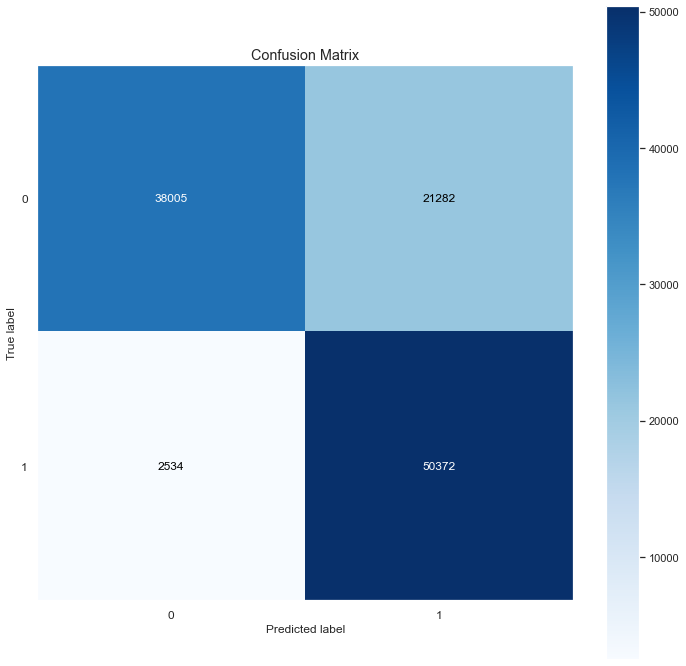

In [183]:
# Accuracy
acc_lr = accuracy_score(y_valid, yhat_lr)
print('Accuracy: {}'.format(acc_lr))

# Balanced Accuracy
balanced_acc_lr = balanced_accuracy_score(y_valid, yhat_lr)
print('Balanced Accuracy: {}'.format(balanced_acc_lr))

# Kappa Score
kappa_lr = cohen_kappa_score(y_valid, yhat_lr)
print('Kappa Score: {}'.format(kappa_lr))

# Classification Report
print(classification_report(y_valid, yhat_lr))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_lr, normalize=False, figsize=(12, 12));

#### 9.2.5.2 Performance - Cross Validation

In [184]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = LogisticRegression(max_iter=400, random_state=42)

# cross validation
result_lr = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_lr

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LogisticRegression,0.7032 +/- 0.0008,0.9521 +/- 0.0008,0.8089 +/- 0.0007,0.5824 +/- 0.0015,0.7967 +/- 0.0008,0.7449 +/- 0.0012,0.847 +/- 0.0009


### 9.2.6 KNN

In [185]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Prediction
yhat_knn = knn.predict(X_valid)

#### 9.2.6.1 Performance

Accuracy: 0.7991764192061893
Balanced Accuracy: 0.8006531212354219
Kappa Score: 0.5987574133977137
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     59287
           1       0.77      0.83      0.80     52906

    accuracy                           0.80    112193
   macro avg       0.80      0.80      0.80    112193
weighted avg       0.80      0.80      0.80    112193



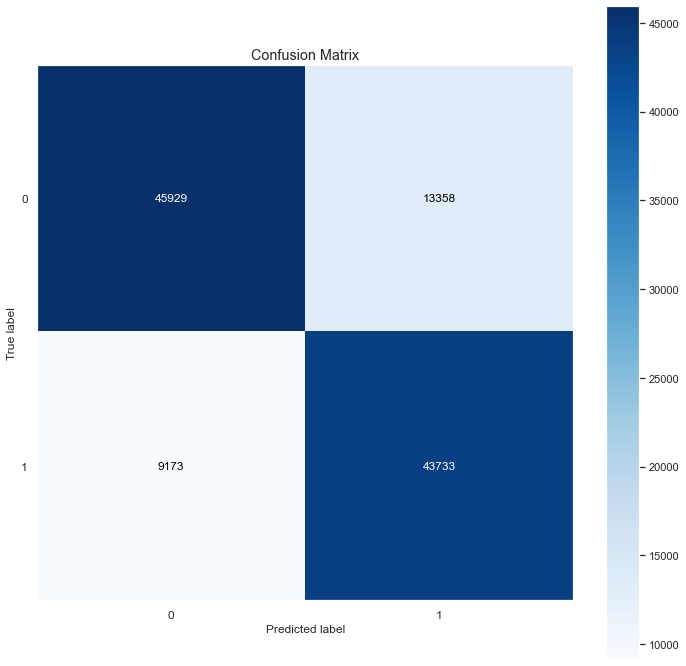

In [186]:
# Accuracy
acc_knn = accuracy_score(y_valid, yhat_knn)
print('Accuracy: {}'.format(acc_knn))

# Balanced Accuracy
balanced_acc_knn = balanced_accuracy_score(y_valid, yhat_knn)
print('Balanced Accuracy: {}'.format(balanced_acc_knn))

# Kappa Score
kappa_knn = cohen_kappa_score(y_valid, yhat_knn)
print('Kappa Score: {}'.format(kappa_knn))

# Classification Report
print(classification_report(y_valid, yhat_knn))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_knn, normalize=False, figsize=(12, 12));

#### 9.2.6.2 Performance - Cross Validation

In [187]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = KNeighborsClassifier()

# cross validation
result_knn = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_knn

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,KNeighborsClassifier,0.7642 +/- 0.001,0.8245 +/- 0.0014,0.7932 +/- 0.0009,0.5949 +/- 0.0018,0.7987 +/- 0.0009,0.8016 +/- 0.0016,0.8722 +/- 0.0008


### 9.2.7 Performance Comparison 

In [188]:
df_compare = pd.concat([result_rf, result_xgb, result_lgbm, result_catb, result_lr, result_knn], axis=0).reset_index(drop=True)
df_compare

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,RandomForestClassifier,0.7 +/- 0.0016,0.9629 +/- 0.0011,0.8107 +/- 0.001,0.5828 +/- 0.0026,0.7973 +/- 0.0013,0.7923 +/- 0.0053,0.8637 +/- 0.0024
1,XGBClassifier,0.7889 +/- 0.0014,0.9061 +/- 0.0017,0.8434 +/- 0.0011,0.6843 +/- 0.0022,0.8449 +/- 0.0011,0.9039 +/- 0.0011,0.9267 +/- 0.0009
2,LGBMClassifier,0.761 +/- 0.001,0.9185 +/- 0.0012,0.8323 +/- 0.0006,0.6537 +/- 0.0013,0.8305 +/- 0.0006,0.8695 +/- 0.0014,0.9043 +/- 0.0008
3,CatBoostClassifier,0.8187 +/- 0.0004,0.8999 +/- 0.0011,0.8574 +/- 0.0004,0.7182 +/- 0.0006,0.861 +/- 0.0003,0.9249 +/- 0.001,0.9425 +/- 0.0005
4,LogisticRegression,0.7032 +/- 0.0008,0.9521 +/- 0.0008,0.8089 +/- 0.0007,0.5824 +/- 0.0015,0.7967 +/- 0.0008,0.7449 +/- 0.0012,0.847 +/- 0.0009
5,KNeighborsClassifier,0.7642 +/- 0.001,0.8245 +/- 0.0014,0.7932 +/- 0.0009,0.5949 +/- 0.0018,0.7987 +/- 0.0009,0.8016 +/- 0.0016,0.8722 +/- 0.0008


# 10.0 Hyperparameter Fine Tuning

- XGBoost
- Lightgbm
- Random Forest

## 10.1 XGBoost Classifier

In [189]:
df_results_xgb = pd.DataFrame()


def tune_xgb(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]
    reg_lambda        = params[7]
    reg_alpha         = params[8]
    

    #Model
    model = XGBClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_weight=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5], gamma=params[6], reg_lambda=params[7],reg_alpha=params[8],
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

    model.fit(X_train, y_train)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(X_valid)

    # Prediction Proba
    yhat_proba = model.predict_proba(X_valid)[:,1]
    # Performance
#     model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc_auc = roc_auc_score(y_valid, yhat_proba)
    
    return -roc_auc



space = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_weight
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500), #n_estimetors
        (1.0, 6.0), #gamma
        (0, 9), #reg_lambda
        (40, 150)]#reg_alpha




result = forest_minimize(tune_xgb, space, random_state=2, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.0015313768522754259, 1, 1, 0.4764787751875451, 0.7423745483918779, 363, 2.651674105019371, 5, 87]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 24.0840
Function value obtained: -0.8305
Current minimum: -0.8305
Iteration No: 2 started. Evaluating function at random point.
[0.001993676426196559, 1, 1, 0.32951022474618274, 0.7645710471385196, 295, 3.4928058502665955, 3, 143]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.5750
Function value obtained: -0.8308
Current minimum: -0.8308
Iteration No: 3 started. Evaluating function at random point.
[0.0018134186856752872, 2, 1, 0.23328852453047533, 0.5884923118339683, 188, 3.5262304506085203, 6, 135]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.0710
Function value obtained: -0.8514
Current minimum: -0.8514
Iteration No: 4 started. Evaluating function at random point.
[0.002679923071652923, 2, 1, 0.10722198726

In [190]:
result_list_xgb = result.x
result_list_xgb
# [0.004274080160850215, 2, 1, 0.2217618233782525, 0.9812297859854912, 464, 4.691998793104503, 9, 147]

[0.004274080160850215,
 2,
 1,
 0.2217618233782525,
 0.9812297859854912,
 464,
 4.691998793104503,
 9,
 147]

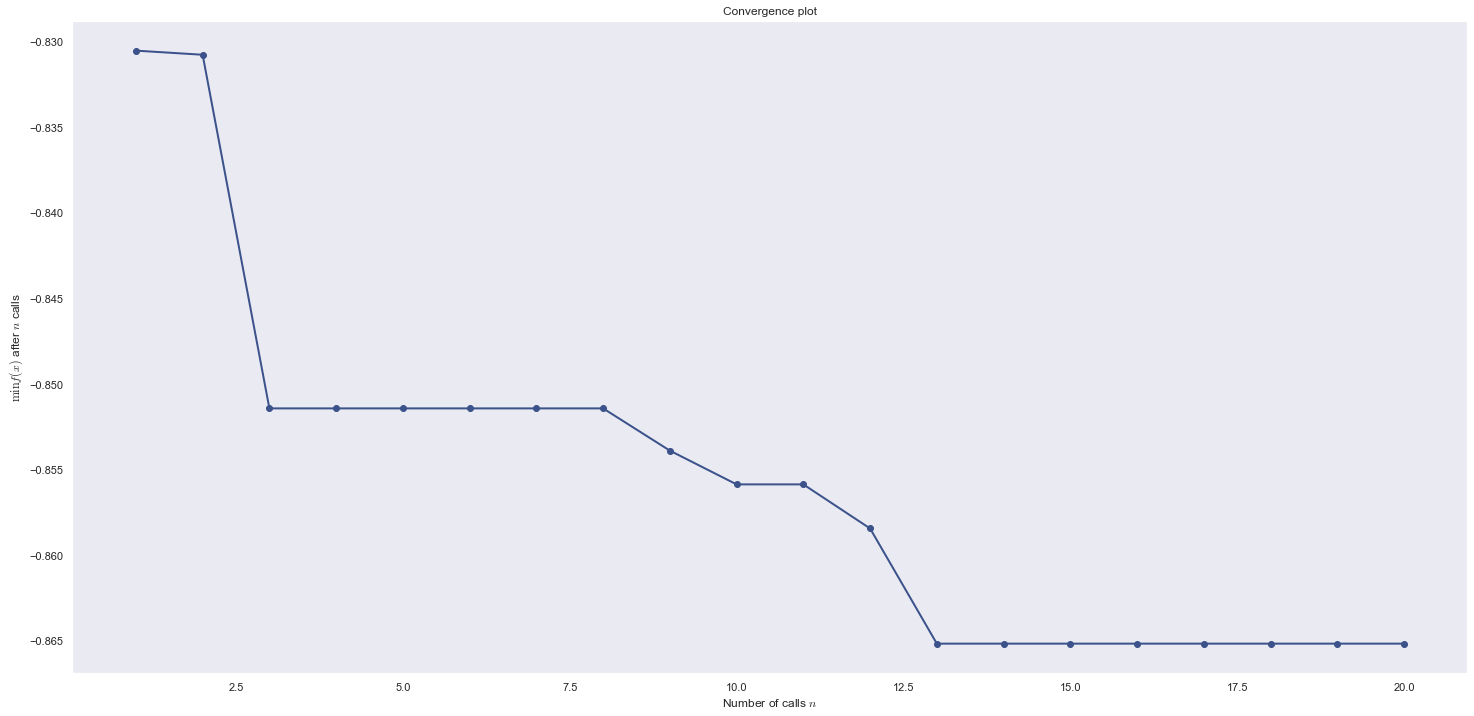

In [191]:
plot_convergence(result);

## 10.2 Lightgbm Classifier

In [192]:
df_results_lgbm = pd.DataFrame()
#df_train_tuning = pd.concat([X_train_cv, y_train_cv], axis=1)

def tune_lgbm(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_samples = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
        
        
    #Model
    model = LGBMClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_samples=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5],
                                    random_state=0, n_jobs=-1)



    model.fit(X_train, y_train)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(X_valid)

    # Prediction Proba
    yhat_proba = model.predict_proba(X_valid)[:,1]
    # Performance
    # model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc_auc = roc_auc_score(y_valid, yhat_proba)
    
    return -roc_auc




space = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_samples
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500)] #n_estimetors



result = forest_minimize(tune_lgbm, space, random_state=42, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.006259548184287541, 1, 1, 0.4008609501227462, 0.7984250789732436, 221]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.9265
Function value obtained: -0.8325
Current minimum: -0.8325
Iteration No: 2 started. Evaluating function at random point.
[0.0014321698289111518, 1, 1, 0.4397792655987209, 0.8005575058716045, 251]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.0730
Function value obtained: -0.7886
Current minimum: -0.8325
Iteration No: 3 started. Evaluating function at random point.
[0.004475983459259065, 1, 2, 0.37489944752007115, 0.9692763545078752, 485]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.8380
Function value obtained: -0.8328
Current minimum: -0.8328
Iteration No: 4 started. Evaluating function at random point.
[0.0015199348301309814, 1, 1, 0.186909009331792, 0.762378215816119, 335]
Iteration No: 4 ended. Evaluation done at random point.


In [193]:
result_list_lgbm = result.x
result_list_lgbm
# [0.009621236402909397, 1, 1, 0.4369731830313443, 0.8401537692938899, 428]

[0.009621236402909397, 1, 1, 0.4369731830313443, 0.8401537692938899, 428]

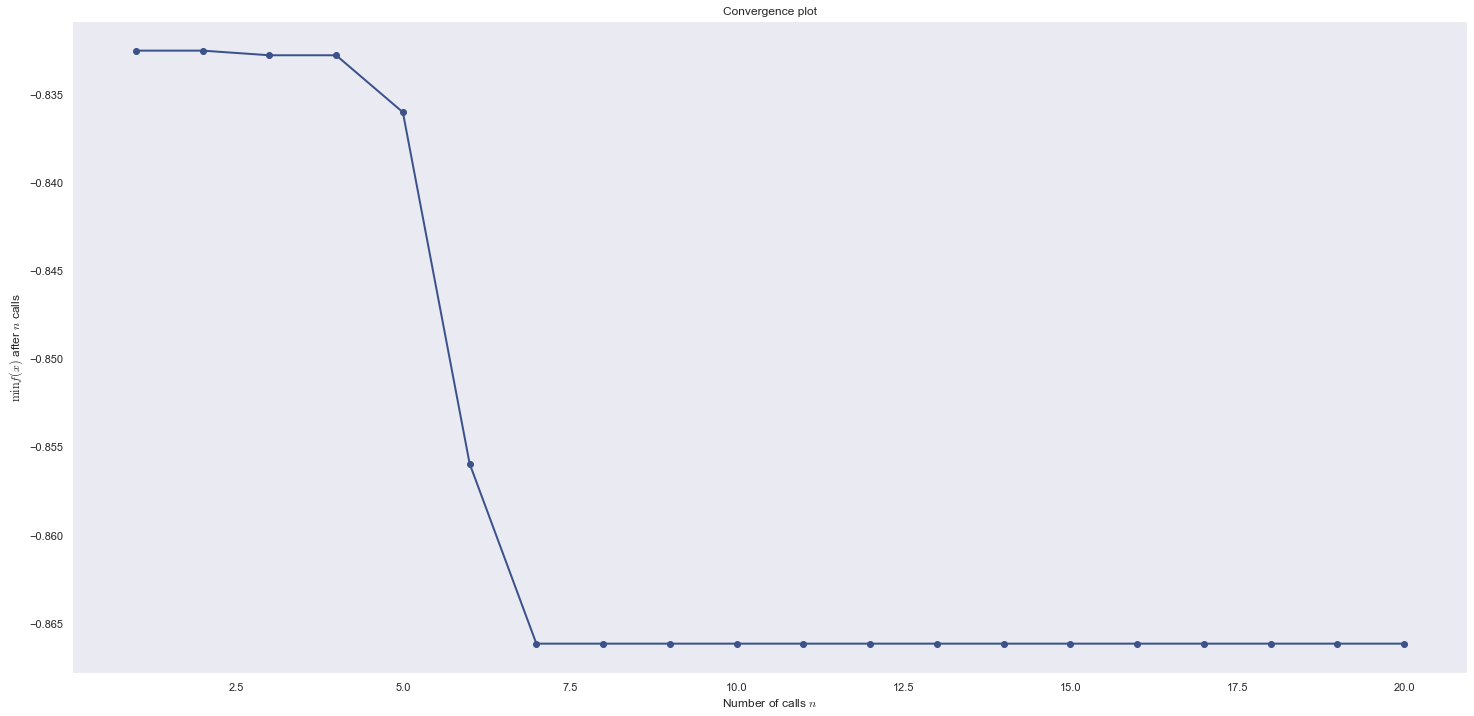

In [194]:
plot_convergence(result);

## 10.4 Random Forest Classifier

In [195]:
df_results_rf = pd.DataFrame()
df_train_tuning = pd.concat([X_train_cv, y_train_cv], axis=1)

def tune_rf(params):
    print(params)
    max_depth = params[0]
    min_samples_leaf = params[1]
    n_estimators = params[2]
    

    #Model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0,
                                       class_weight='balanced', n_jobs=-1)


    model.fit(X_train, y_train)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(X_valid)

    # Prediction Proba
    yhat_proba = model.predict_proba(X_valid)[:,1]
    # Performance
    # model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc_auc = roc_auc_score(y_valid, yhat_proba)
    
    return -roc_auc


space = [(1, 2), #max_depth
        (1, 2), #min_samples_leaf 
        (100, 500)] #n_estimetors



result = forest_minimize(tune_rf, space, random_state=42, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[2, 1, 370]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.3565
Function value obtained: -0.8639
Current minimum: -0.8639
Iteration No: 2 started. Evaluating function at random point.
[1, 2, 288]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.5867
Function value obtained: -0.8424
Current minimum: -0.8639
Iteration No: 3 started. Evaluating function at random point.
[1, 1, 221]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.6543
Function value obtained: -0.8424
Current minimum: -0.8639
Iteration No: 4 started. Evaluating function at random point.
[1, 1, 430]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.5481
Function value obtained: -0.8425
Current minimum: -0.8639
Iteration No: 5 started. Evaluating function at random point.
[1, 2, 472]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.0756
Function value obtai

In [196]:
result_list_rf = result.x
result_list_rf
# [2, 1, 230]

[2, 2, 188]

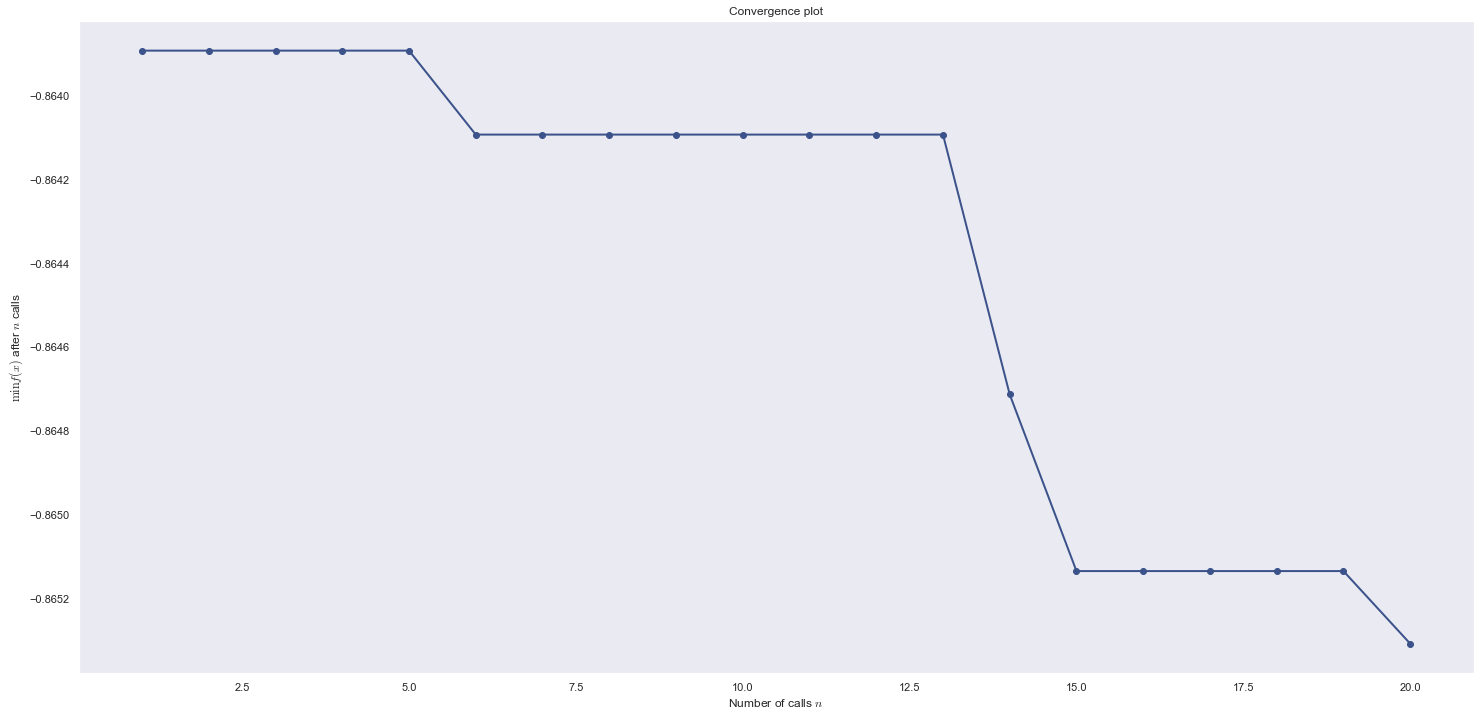

In [197]:
plot_convergence(result);

# 11.0 Final Model

- XGBoost
- Lightgbm

## 11.1 XGBoost Classifier

In [198]:
params_xgb = result_list_xgb

lr                = params_xgb[0]
max_depth         = params_xgb[1]
min_child_weight  = params_xgb[2]
subsample         = params_xgb[3]
colsample_bytree  = params_xgb[4]
n_estimators      = params_xgb[5]
gamma             = params_xgb[6]
reg_lambda        = params_xgb[7]
reg_alpha         = params_xgb[8]

#[0.023230148647550936, 3, 1, 0.3140586401000465, 0.37388940456063163, 650, 0.4269876463197445]
#Model
xgb = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_weight=min_child_weight,
                    subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                     booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)


xgb.fit(X_train_cv, y_train_cv)

# Prediction
yhat_xgb = xgb.predict(X_test)

# Prediction proba
yhat_proba_xgb = xgb.predict_proba(X_test)[:,1]

### 11.1.1 Performance

In [199]:
# Model Name
model_name = type(xgb).__name__

# Scores
final_scores = ml_scores(model_name, y_test, yhat_xgb, yhat_proba_xgb)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.70533,0.958118,0.812516,0.589558,0.800466,0.784468,0.864071


              precision    recall  f1-score   support

           0       0.95      0.64      0.77     32938
           1       0.71      0.96      0.81     29392

    accuracy                           0.79     62330
   macro avg       0.83      0.80      0.79     62330
weighted avg       0.83      0.79      0.79     62330



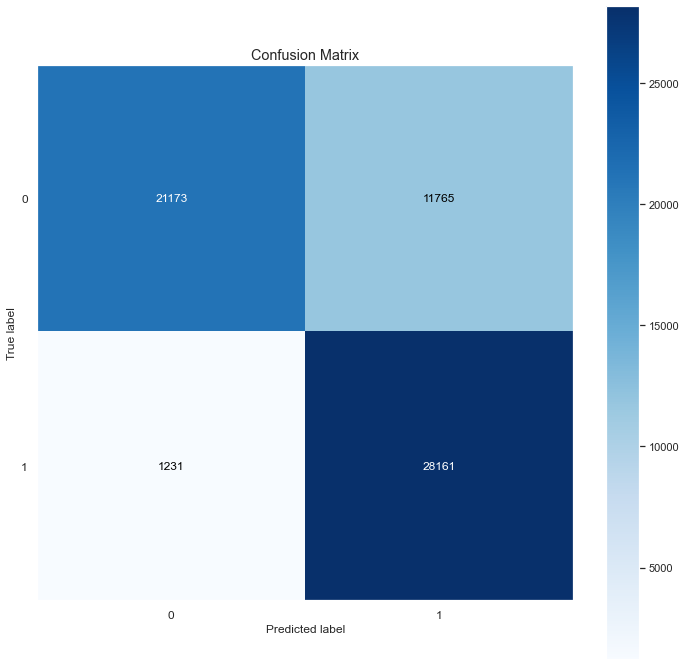

In [200]:
# Classification Report
print(classification_report(y_test, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_xgb, normalize=False, figsize=(12, 12));

### 11.1.2 Performance - Cross Validation

In [201]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_weight=min_child_weight,
                    subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                     booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

# cross validation
result_xgb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.706 +/- 0.0008,0.9584 +/- 0.001,0.8131 +/- 0.0008,0.5909 +/- 0.0018,0.8011 +/- 0.0009,0.7852 +/- 0.002,0.865 +/- 0.0012


## 11.2 LightGBM Classifier

In [202]:
params_lgbm = result_list_lgbm

lr                = params_lgbm[0]
max_depth         = params_lgbm[1]
min_child_samples = params_lgbm[2]
subsample         = params_lgbm[3]
colsample_bytree  = params_lgbm[4]
n_estimators      = params_lgbm[5]
        
#Model
lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_samples=min_child_samples,
                                subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators,
                                random_state=0, n_jobs=-1)


lgbm.fit(X_train_cv, y_train_cv)

# Prediction
yhat_lgbm = lgbm.predict(X_test)

# Prediction proba
yhat_proba_lgbm = lgbm.predict_proba(X_test)[:,1]

### 11.2.1 Performance

In [203]:
# Model Name
model_name = type(lgbm).__name__

# Scores
final_scores = ml_scores(model_name, y_test, yhat_lgbm, yhat_proba_lgbm)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,LGBMClassifier,0.698888,0.962065,0.809626,0.580423,0.796094,0.783484,0.8645


              precision    recall  f1-score   support

           0       0.95      0.63      0.76     32938
           1       0.70      0.96      0.81     29392

    accuracy                           0.79     62330
   macro avg       0.82      0.80      0.78     62330
weighted avg       0.83      0.79      0.78     62330



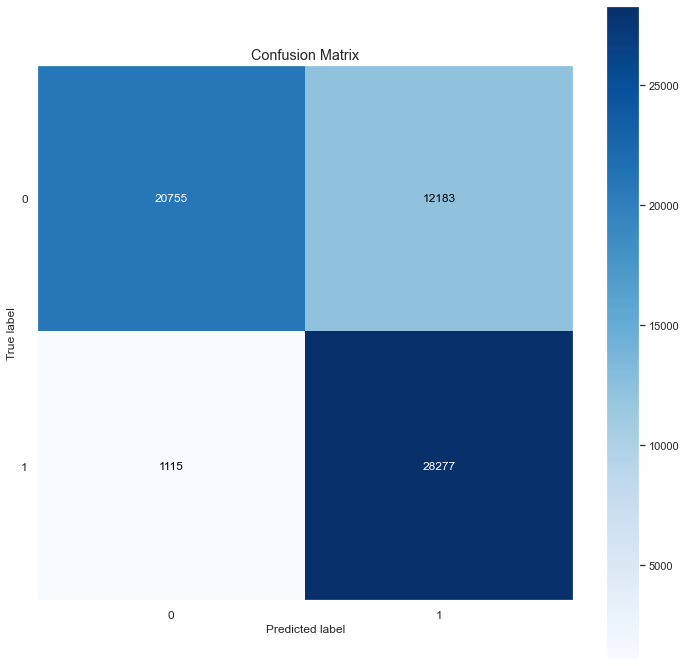

In [204]:
# Classification Report
print(classification_report(y_test, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_lgbm, normalize=False, figsize=(12, 12));

### 11.2.2 Performance - Cross Validation

In [205]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_samples=min_child_samples,
                                subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators,
                                random_state=0, n_jobs=-1)


# cross validation
result_lgbm = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LGBMClassifier,0.6997 +/- 0.0007,0.962 +/- 0.001,0.8101 +/- 0.0005,0.5818 +/- 0.0013,0.7968 +/- 0.0006,0.7849 +/- 0.0022,0.8657 +/- 0.0012


## 11.3 Models Compare

In [206]:
df_compare = pd.concat([result_xgb, result_lgbm], axis=0).reset_index(drop=True)
df_compare

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.706 +/- 0.0008,0.9584 +/- 0.001,0.8131 +/- 0.0008,0.5909 +/- 0.0018,0.8011 +/- 0.0009,0.7852 +/- 0.002,0.865 +/- 0.0012
1,LGBMClassifier,0.6997 +/- 0.0007,0.962 +/- 0.001,0.8101 +/- 0.0005,0.5818 +/- 0.0013,0.7968 +/- 0.0006,0.7849 +/- 0.0022,0.8657 +/- 0.0012


## 11.4 Final Model Evaluation

In [207]:
####### Teste
df_test = pd.read_feather('../00-Data/test_data.feather')




#====================================================== feature Engineering ======================================================#
# Age Stage
df_test['age_stage'] = df_test['age'].apply(lambda row: age_stage(row))

# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df_test['vehicle_age'] = df_test['vehicle_age'].map(vehicle_age_mapping)

# vehicle demage versus license
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df_test['vehicle_damage'] = df_test['vehicle_damage'].map(vehicle_damage_mapping)
df_test['vehicle_damage_license'] = df_test.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


# vehicle_damage_vehicle_age
df_test['vehicle_damage_vehicle_age'] = df_test.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

# age / mean_age_by_region_code
region_code_mean_age = pd.DataFrame(df_test.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df_test = pd.merge(df_test, region_code_mean_age, how='left', on='region_code')

df_test['age_mean_age_by_region_code'] = df_test['age'] / df_test['mean_age_by_region_code']
del region_code_mean_age


# age / mean_age_by_policy_sales_channel
policy_sales_channel_mean_age = pd.DataFrame(df_test.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df_test = pd.merge(df_test, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df_test['age_mean_age_by_policy_sales_channel'] = df_test['age'] / df_test['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# annual_premium / mean_annual_premium_by_region_code
region_code_mean_annual_premium = pd.DataFrame(df_test.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df_test = pd.merge(df_test, region_code_mean_annual_premium, how='left', on='region_code')

df_test['annual_premium_mean_annual_premium_by_region_code'] = df_test['annual_premium'] / df_test['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# annual_premium / mean_annual_premium_by_policy_sales_channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df_test.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df_test = pd.merge(df_test, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df_test['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df_test['annual_premium'] / df_test['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

# age / vintage
df_test['age_vintage'] = (df_test['age']*365) / df_test['vintage']



#====================================================== Data Preparation ======================================================#

# Numerical
num_attributes_teste = df_test.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes_teste = df_test.select_dtypes(exclude=['int64', 'float64'])


# Dummy variable
df_teste_dummy = pd.get_dummies(cat_attributes_teste)

# Join id and country_destination
df_teste = pd.concat([num_attributes_teste, df_teste_dummy], axis=1)

cols_selected = ['region_code',
                 'policy_sales_channel',
                 'previously_insured',
                 #'vintage',
                 'vehicle_damage_license',
                 'vehicle_damage_vehicle_age',
                 #'age_mean_age_by_region_code',
                 'age_mean_age_by_policy_sales_channel',
                 #'annual_premium_mean_annual_premium_by_region_code',
                 #'annual_premium_mean_annual_premium_by_policy_sales_channel',
                 'age_vintage']



X_test_eval = df_teste[cols_selected]
y_test_eval = df_teste['response'].copy()

In [208]:
# Prediction
yhat_xgb_eval = xgb.predict(X_test_eval)

# Prediction proba
yhat_proba_xgb_eval = xgb.predict_proba(X_test_eval)[:,1]

In [209]:
# Model Name
model_name = type(xgb).__name__

# Scores
final_scores = ml_scores(model_name, y_test_eval, yhat_xgb_eval, yhat_proba_xgb_eval)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.254585,0.962856,0.402695,0.25905,0.784531,0.306882,0.832016


              precision    recall  f1-score   support

           0       0.99      0.61      0.75     66880
           1       0.25      0.96      0.40      9342

    accuracy                           0.65     76222
   macro avg       0.62      0.78      0.58     76222
weighted avg       0.90      0.65      0.71     76222



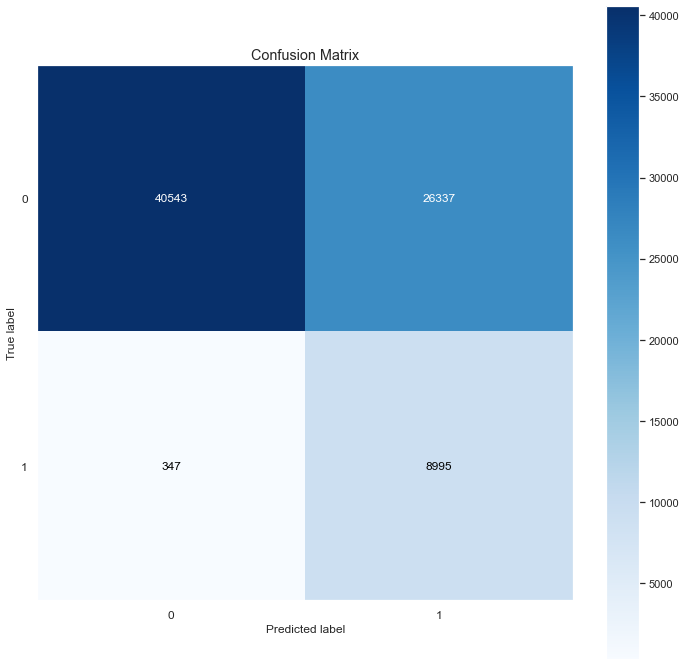

In [210]:
# Classification Report
print(classification_report(y_test_eval, yhat_xgb_eval))

# Confusion matrix
plot_confusion_matrix(y_test_eval, yhat_xgb_eval, normalize=False, figsize=(12, 12));

## 11.5 Model Interpretation (shap)

In [211]:
# print the JS visualization code to the notebook
shap.initjs()

In [212]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_cv)

In [213]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_cv.iloc[0,:])

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [214]:
shap.force_plot(explainer.expected_value, shap_values[10000,:], X_train_cv.iloc[10000,:])

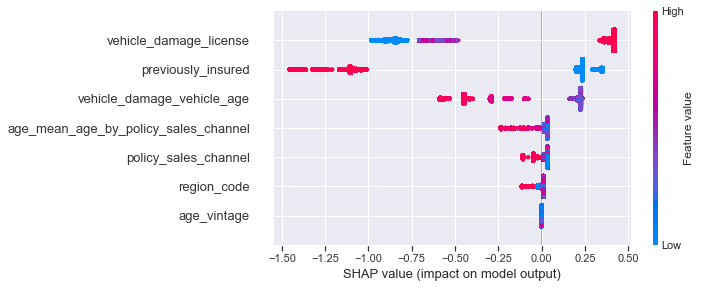

In [215]:
shap.summary_plot(shap_values[:,:], X_train_cv)

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

In [ ]:
#https://www.brainshark.com/ideas-blog/2017/october/cross-sell-metrics-b2b-sales
#https://www.analyticsvidhya.com/blog/2015/08/learn-cross-selling-upselling/
# https://addepto.com/up-selling-cross-selling-5-reasons-use-machine-learning/